In [1]:
import tinkhorn
import numpy as np
import matplotlib.pyplot as plt

In [416]:
beta = 0.01 # regularization coefficient 

# pointcloud: X - center cloud, Y - 3 clouds near X
n, m, d = 60, 80, 2
bin_size = 16
percentile = [90, 99]
percentile_b = round((1 - (n * m) * ((100 - percentile[1]) / 100) / (bin_size ** 4)) * 100, 2)
percentile_b = [(percentile_b * 10) % 100, percentile_b]
gauss = lambda q, a, c: a * np.random.randn(q, d) + (np.tile(c, (q, 1)))
X = np.random.randn(n, d) * .3
Y = np.vstack([gauss(int(m / 2), .5, [0, 1.6]), 
               gauss(int(m / 4), .3, [-1, -1]),
               gauss(int(m / 4), .3, [1, -1])])

# pointcloud: X - center square cloud, Y - circle cloud around X
n, m, d = 300, 200, 2
bin_size = 32
percentile = [99, 99.9]
percentile_b = round((1 - (n * m) * ((100 - percentile[1]) / 100) / (bin_size ** 4)) * 100, 2)
percentile_b = [(percentile_b * 10) % 100, percentile_b]
X = np.random.rand(n, d) - .5
theta = 2 * np.pi * np.random.rand(m, 1)
r = .8 + .2 * np.random.rand(m, 1)
Y = np.hstack((np.cos(theta) * r, np.sin(theta) * r))

In [417]:
# normalize = lambda a: a/np.sum(a)
# a = normalize(np.random.rand(n, 1))
# b = normalize(np.random.rand(m, 1))
a = np.full((n, 1), 1 / n)
b = np.full((m, 1), 1 / m)

In [418]:
plotp = lambda x, col: plt.scatter(x[:, 0], x[:, 1], s=200, edgecolors="k", c=col, linewidths=2)

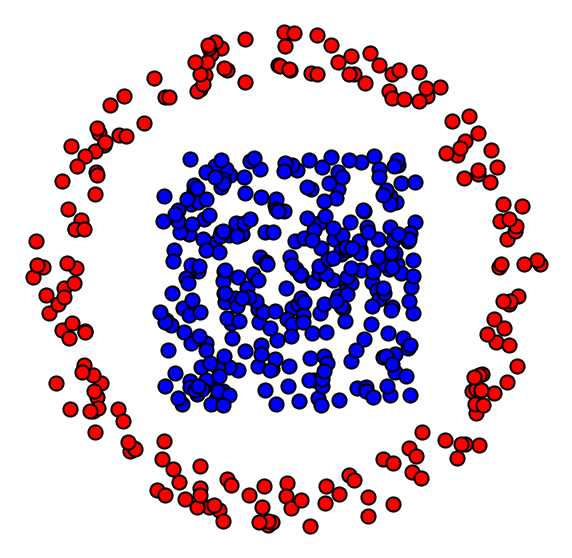

In [419]:
plt.figure(figsize = (10, 10))
plt.axis("off")
plotp(X, 'b')
plotp(Y, 'r')
plt.xlim(np.min(Y[:, 0]) - .1, np.max(Y[:, 0]) + .1)
plt.ylim(np.min(Y[:, 1]) - .1, np.max(Y[:, 1]) + .1)
plt.show()

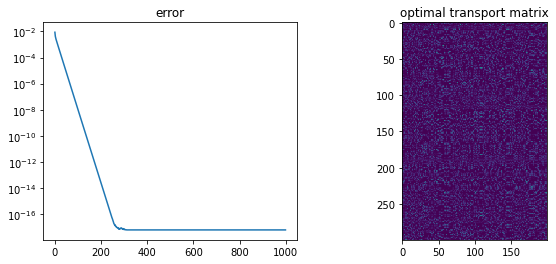

In [420]:
K, a, b = tinkhorn.sinkhorn(X, Y, beta=beta * 5, max_iter=1000, 
                            early_stopping=False, plot=True)

In [421]:
P = np.dot(np.dot(np.diag(a), K), np.diag(b))

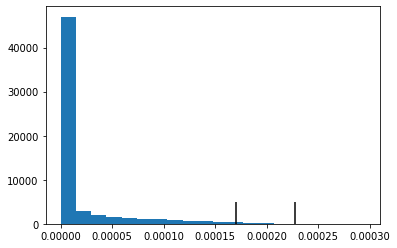

In [422]:
bounds = np.percentile(P.ravel(), percentile)
plt.hist(P.ravel(), bins=20)
plt.vlines(bounds, 0, 5000)
plt.show()

In [423]:
(P>0).sum(), (P > bounds[0]).sum(), (P > bounds[1]).sum(), np.prod(P.shape)

(60000, 600, 60, 60000)

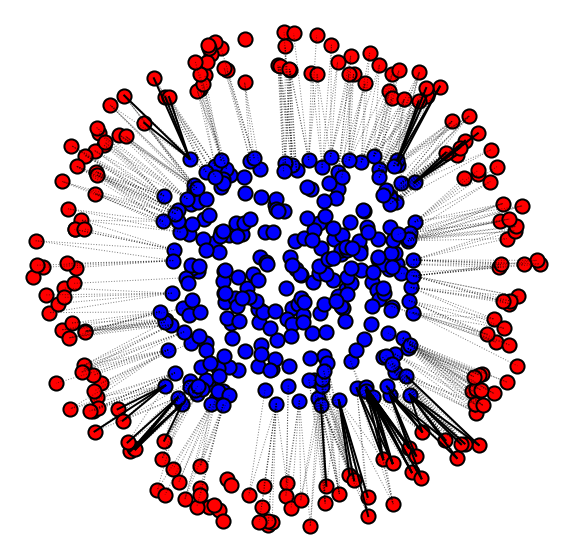

In [424]:
plt.figure(figsize = (10,10))
plotp(X, 'b')
plotp(Y, 'r')

A = P * (P > bounds[1])
i,j = np.where(A != 0)
plt.plot([X[i, 0], Y[j, 0]], [X[i, 1], Y[j, 1]], 'k', lw = 2)

A = P * (P > bounds[0])
i,j = np.where(A != 0)
plt.plot([X[i, 0], Y[j, 0]], [X[i, 1], Y[j, 1]], 'k:', alpha=0.5, lw = 1)

plt.axis("off")
plt.xlim(np.min(Y[:, 0]) - .1, np.max(Y[:, 0]) + .1)
plt.ylim(np.min(Y[:, 1]) - .1, np.max(Y[:, 1]) + .1)

plt.show()

#iterations=999,  err=4.458178141967733e-17


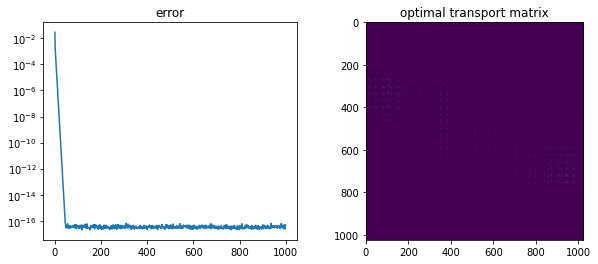

In [425]:
K, a, b, bins, x, y = tinkhorn.sinkhorn_toeplitz(X, Y, bin_size=bin_size, beta=beta*20, max_iter=1000, 
                                           early_stopping=False, plot=True)

In [426]:
P = np.dot(np.dot(np.diag(a), K), np.diag(b))

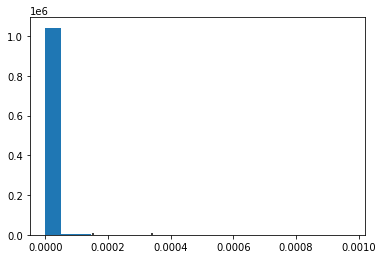

In [427]:
bounds = np.percentile(P.ravel(), percentile_b)
plt.hist(P.ravel(), bins=20)
plt.vlines(bounds, 0, 10000)
plt.show()

In [428]:
(P>0).sum(), (P > bounds[0]).sum(), (P > bounds[1]).sum(), 256*256

(28880, 1049, 105, 65536)

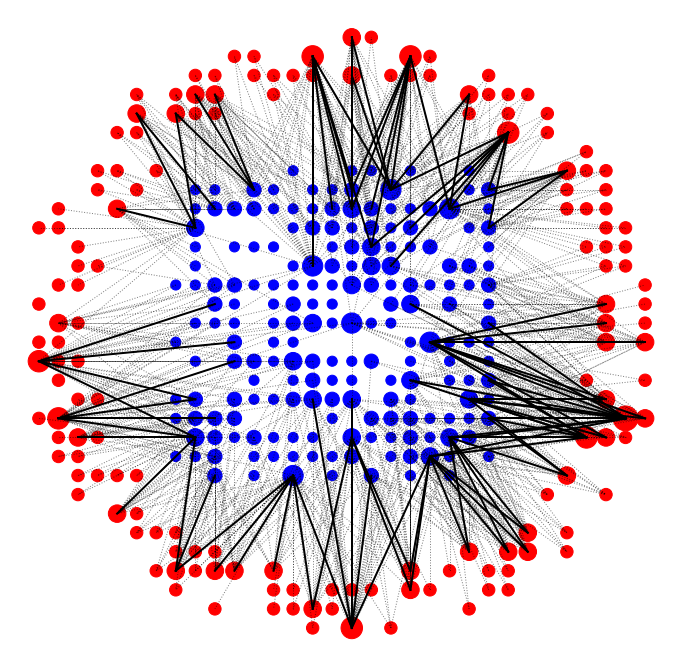

In [429]:
plt.figure(figsize = (12,12))
plt.scatter(bins[:,0], bins[:,1], s=x * len(x) * 30, c='b')
plt.scatter(bins[:,0], bins[:,1], s=y * len(y) * 30, c='r')

A = P * (P > bounds[1])
i, j = np.where(A != 0)
plt.plot([bins[i, 0], bins[j, 0]], [bins[i, 1], bins[j, 1]], 'k', lw = 2)

A = P * (P > bounds[0])
i,j = np.where(A != 0)
plt.plot([bins[i, 0], bins[j, 0]], [bins[i, 1], bins[j, 1]], 'k:', alpha=0.5, lw = 1)

plt.axis("off")
plt.xlim(np.min(bins[:, 0]) - .1, np.max(bins[:, 0]) + .1)
plt.ylim(np.min(bins[:, 1]) - .1, np.max(bins[:, 1]) + .1)

plt.show()

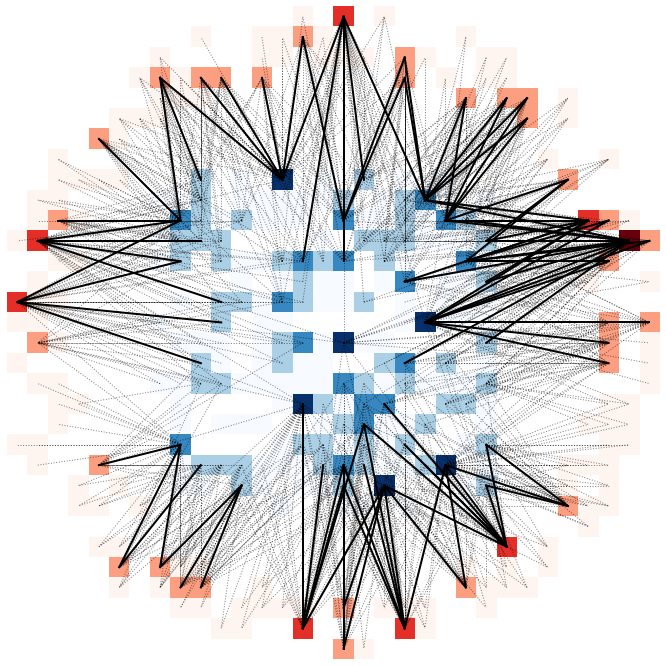

In [430]:
Xbins, Ybins = np.meshgrid(np.arange(bin_size), np.arange(bin_size))
Xbins = Xbins.ravel()
Ybins = Ybins.ravel()

plt.figure(figsize = (12,12))
plt.imshow(np.where(x > 0, x, np.nan).reshape(bin_size, bin_size), cmap='Blues')
plt.imshow(np.where(y > 0, y, np.nan).reshape(bin_size, bin_size), cmap='Reds')

A = P * (P > bounds[1])
i, j = np.where(A != 0)
plt.plot([Xbins[i], Xbins[j]], [Ybins[i], Ybins[j]], 'k', lw = 2)

A = P * (P > bounds[0])
i,j = np.where(A != 0)
plt.plot([Xbins[i], Xbins[j]], [Ybins[i], Ybins[j]], 'k:', alpha=0.5, lw = 1)

plt.axis("off")
plt.show()